In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from emlp.equivariant_subspaces import T,Scalar,Matrix,Vector,Quad,repsize
from emlp.groups import SO,O
from emlp.mlp import MLP, EMLP,LieLinear
import itertools
import numpy as np
import torch
from emlp.datasets import Inertia

In [2]:
# A = np.zeros((3,3))
# rots = [np.copy(A) for i in [1,2,3]]
# rots[0][0,1] = 1
# rots[1][1,2] =1
# rots[2][2,0] = 1
# rots = [Ai-Ai.T for Ai in rots]

e3 = np.zeros((3,3,3))
for n,(i,j,k) in enumerate(itertools.permutations((0,1,2))):
    e3[i,j,k] = 2*((n+1)%2-.5)
    
e2 = np.zeros((1,2,2))
for n,(i,j) in enumerate(itertools.permutations((0,1))):
    e2[0,i,j] = 2*((n+1)%2-.5)
    
A = np.zeros((4,4))
rots = [np.copy(A) for i in [1,2,3]]
rots[0][1,2] = 1
rots[1][2,3] =1
rots[2][3,1] = 1
rots = [Ai-Ai.T for Ai in rots]
lorentzs = [np.copy(A) for i in [1,2,3]]
lorentzs[0][0,1] = 1
lorentzs[1][0,2] =1
lorentzs[2][0,3] = 1
lorentzs = [Ai+Ai.T for Ai in lorentzs]
e4 = lorentzs+rots

In [3]:
repmiddle = 100*T(0)+30*T(1)+10*T(2)+3*T(3)

In [4]:
repmiddle

100T(0, 0)+30T(1, 0)+10T(2, 0)+3T(3, 0)

In [5]:
repmiddle*repmiddle

10000T(0, 0)+6000T(1, 0)+2900T(2, 0)+1200T(3, 0)+280T(4, 0)+60T(5, 0)+9T(6, 0)

In [6]:
# ds = Inertia(10)
# repmiddle = 100*T(0)+30*T(1)+10*T(2)+3*T(3)#+1*T(4)
# model = EMLP(ds.rep_in,ds.rep_out,repmiddle,3,e3)

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from oil.utils.utils import LoaderTo, cosLr, islice, export,FixedNumpySeed
from oil.tuning.study import train_trial
from oil.datasetup.datasets import split_dataset
from oil.model_trainers.classifier import Regressor
from functools import partial

repmiddle = 100*T(0)+30*T(1)+10*T(2)+3*T(3)#+1*T(4)

def makeTrainer(*,dataset=Inertia,network=EMLP,num_epochs=500,ndata=1000,seed=2020,
                bs=200,lr=1e-2,optim=AdamW,device='cuda',split={'train':-1,'test':.2},
                net_config={'rep_middle':repmiddle,'num_layers':4,'algebra':SO(3)},opt_config={'weight_decay':3e-6},
                trainer_config={'log_dir':None,'log_args':{'minPeriod':.02}},save=False):

    # Prep the datasets splits, model, and dataloaders
    with FixedNumpySeed(seed):
        datasets = split_dataset(dataset(ndata),splits=split)

    device = torch.device(device)
    model = network(datasets['train'].rep_in,datasets['train'].rep_out,**net_config).to(device)
    dataloaders = {k:LoaderTo(DataLoader(v,batch_size=bs,shuffle=(k=='train'),
                num_workers=0,pin_memory=False),device) for k,v in datasets.items()}
    dataloaders['Train'] = dataloaders['train']
    opt_constr = partial(optim, lr=lr, **opt_config)
    lr_sched = cosLr(num_epochs)
    return Regressor(model,dataloaders,opt_constr,lr_sched,**trainer_config)

In [3]:
trainer = makeTrainer(network=EMLP)
trainer.train(500)

W components:90900 dim:8605 shape:(404, 225) rep:4290T(0)+5905T(1)+2780T(2)+740T(3)+205T(4)+30T(5) @ d=3
bias components:404 dim:156 shape:143T(0)+30T(1)+10T(2)+3T(3) @ d=3 rep:143T(0)+30T(1)+10T(2)+3T(3) @ d=3
W components:309060 dim:47296 shape:(404, 765) rep:34749T(0)+15870T(1)+7090T(2)+2787T(3)+560T(4)+120T(5)+18T(6) @ d=3
bias components:404 dim:156 shape:143T(0)+30T(1)+10T(2)+3T(3) @ d=3 rep:143T(0)+30T(1)+10T(2)+3T(3) @ d=3
W components:309060 dim:47296 shape:(404, 765) rep:34749T(0)+15870T(1)+7090T(2)+2787T(3)+560T(4)+120T(5)+18T(6) @ d=3
bias components:404 dim:156 shape:143T(0)+30T(1)+10T(2)+3T(3) @ d=3 rep:143T(0)+30T(1)+10T(2)+3T(3) @ d=3
W components:3249 dim:178 shape:(9, 361) rep:100T(2)+30T(3)+10T(4)+3T(5) @ d=3
bias components:9 dim:1 shape:T(2) @ d=3 rep:T(2) @ d=3


/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


   Minibatch_Loss     Train_MSE   lr0      test_MSE
0      171.757706  13251.418213  0.01  12066.899414
    Minibatch_Loss  Train_MSE      lr0   test_MSE
42        7.010511   6.782139  0.00999  10.740815
    Minibatch_Loss  Train_MSE       lr0  test_MSE
84        3.999664   4.605397  0.009958   7.33861


KeyboardInterrupt: 

In [41]:
import scipy as sp
from scipy.linalg import expm

In [42]:
x = next(iter(trainer.dataloaders['test']))[0]
xsmall = x[:1]

In [43]:
R = expm(e3[0])
Rin = torch.from_numpy(trainer.dataloaders['train'].dataset.rep_in.rho(R)).to(x.device,x.dtype)
Rout = torch.from_numpy(trainer.dataloaders['train'].dataset.rep_out.rho(R)).to(x.device,x.dtype)
from oil.utils.utils import Eval
with Eval(trainer.model):
    print(trainer.model(xsmall@Rin.T))
    print(trainer.model(xsmall)@Rout.T)

tensor([[12.8673,  1.5805,  0.1665,  1.5767, 12.4767, -2.3052,  0.1911, -2.4030,
          3.9754]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([[10.7683,  0.8945, -0.6628,  0.9196, 11.0522, -2.0466, -0.6651, -2.0622,
          2.5832]], device='cuda:0', grad_fn=<MmBackward>)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_mlp['Model']="MLP"
df_e["Model"]="EMLP"
df_all = pd.concat([df_mlp,df_e])

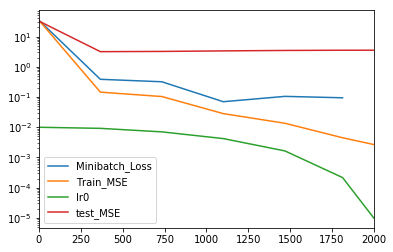

In [38]:
df_mlp.plot()
plt.yscale('log')

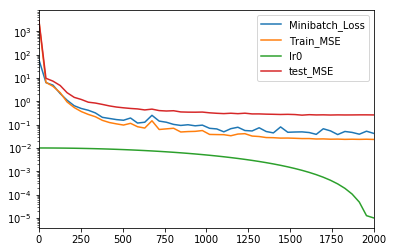

In [39]:
df_e.plot()
plt.yscale('log')

In [28]:

#df_e = trainer.logger.scalar_frame

sns.lineplot(y='test_MSE',data=df_all,hue="Model")
plt.yscale('log')
plt.show()

ValueError: Either both or neither of `x` and `y` must be specified (but try passing to `data`, which is more flexible).

In [21]:
#repmiddle = 30*T(0)+10*T(1)+5*T(2)+2*T(3)#+2*T(3,0)+2*T(2,1)+2*T(1,2)+2*T(0,3)
repmiddle =100*T(0)+30*T(1)+10*T(2)+3*T(3)#+2*T(3,0)+2*T(2,1)+2*T(1,2)+2*T(0,3)

In [22]:
repmiddle(e2)

2T(0)+2T(1)+2T(2)+T(3)+T(4) @ d=2

In [23]:
#(repmiddle*repmiddle.T).symmetric_subspace()[0]

In [24]:
#(repmiddle*repmiddle.T).size()

In [25]:
repmiddle*repmiddle#.T

4T(0)+8T(1)+12T(2)+12T(3)+12T(4)+8T(5)+5T(6)+2T(7)+T(8) @ d=2

In [26]:
from emlp.mlp import capped_tensor_product

In [27]:
v = repmiddle.show_subspace()

In [28]:
v

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970])

In [29]:
outrep,outv = cappedTensorProduct(repmiddle,v,repmiddle)

In [30]:
#(repmiddle*repmiddle).ranks

In [31]:
outrep.ranks

[(0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (3, 0),
 (4, 0)]

In [32]:
v

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970])

In [33]:
outv

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970,   1.0000,   1.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000])

In [34]:
outrep.drho(e2[0])@outv.numpy()

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.38418579e-07,  2.38418579e-07,
        2.38418579e-07,  2.38418579e-07,  2.38418579e-07,  2.38418579e-07,
        2.38418579e-07, -2.38418579e-07,  2.38418579e-07,  2.38418579e-07,
        2.38418579e-07, -2.38418579e-07,  2.38418579e-07, -2.38418579e-07,
       -2.38418579e-07, -2.38418579e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [21]:
outrep.drho(e2[0]).shape

(16, 16)

$SO(2): \quad 1,\_, \delta_{ij},\_, \epsilon_{ij}, ...$

In [14]:
for i in range(8):
    print(f"T({i}): {T(i)(O(2)).symmetric_subspace()[0]}")

T(0): 1
T(1): 0
T(2): 0
T(3): 0
T(4): 0
T(5): 0
T(6): 0
T(7): 0


In [4]:
from emlp.equivariant_subspaces import T
from emlp.groups import SO,O,C,D,Scaling,Parity,TimeReversal,Lorentz,SO13p,SO13
rep = T(2)(C(6))
A = rep.show_subspace()

In [5]:
R = rep.G.sample()
Rrep = rep.rho(R)
print(Rrep@A.numpy())
print(A)

[-0.70710677  1.41421354 -1.41421354 -0.70710677]
tensor([-0.7071,  1.4142, -1.4142, -0.7071])


In [6]:
print(f"T({4}): {T(4)(e2).show_subspace().reshape(2,2,2,2)}")

NameError: name 'e2' is not defined

$SO(3): \quad 1, \_, \delta_{ij}, \epsilon_{ijk}, \delta_{ij}\delta_{k\ell}, \delta_{ik}\delta_{j\ell}, \delta_{jk}\delta_{i\ell}, ...$

In [11]:
for i in range(8):
    print(f"T({i}): {T(i)(e3).symmetric_subspace()[0]}")

T(0): 1
T(1): 0
T(2): 1
T(3): 1
T(4): 3
T(5): 6
T(6): 15
T(7): 36


$SO^+(1,3): \quad 1, \_, \delta_{\mu}^\nu, \eta_{\mu\nu}, \eta^{\mu\nu},\_,\epsilon_{\mu\nu\sigma\tau},\eta_{\mu\nu}\eta_{\sigma\tau},...$

In [5]:
for i in range(6):
    for j in range(i+1):
        print(f"T{i-j,j}: {T(i-j,j)(SO13).symmetric_subspace()[0]}")

T(0, 0): 1
T(1, 0): 0
T(0, 1): 0
T(2, 0): 1
T(1, 1): 1
T(0, 2): 1
T(3, 0): 0
T(2, 1): 0
T(1, 2): 0
T(0, 3): 0
T(4, 0): 3
T(3, 1): 3
T(2, 2): 3
T(1, 3): 3
T(0, 4): 3
T(5, 0): 0
T(4, 1): 0
T(3, 2): 0
T(2, 3): 0
T(1, 4): 0
T(0, 5): 0


#### $SO(2)_{xy}$ in $\mathbb{R}^3$

In [7]:
for i in range(8):
    print(f"T({i}): {T(i)(e3[:1]).symmetric_subspace()[0]}")

T(0): 1
T(1): 1
T(2): 3
T(3): 7
T(4): 19
T(5): 51
T(6): 141
T(7): 393


In [15]:
for i in range(8):
    print(f"T({i}): {T(i)(0*e3[:1]).symmetric_subspace()[0]}")

T(0): 1
T(1): 3
T(2): 9
T(3): 27
T(4): 81
T(5): 243
T(6): 729
T(7): 2187


In [ ]:
for i in range(6):
    for j in range(i+1):
        print(f"T{i-j,j}: {T(i-j,j)(Lorentz).symmetric_subspace()[0]}")

T(0, 0): 1
T(1, 0): 0
T(0, 1): 0
T(2, 0): 1
T(1, 1): 1
T(0, 2): 1
T(3, 0): 0
T(2, 1): 0
T(1, 2): 0
T(0, 3): 0
T(4, 0): 3
T(3, 1): 3
T(2, 2): 3
T(1, 3): 3
T(0, 4): 3
T(5, 0): 0
T(4, 1): 0
T(3, 2): 0


In [9]:
import numpy as np

In [10]:
np.ones(3)@e3

array([[ 0., -1.,  1.],
       [-1.,  0.,  1.],
       [-1.,  1.,  0.]])

In [11]:
e3.shape

(3, 3, 3)

In [1]:
from emlp.groups import *

In [6]:
M = O13.sample()

In [7]:
eta = np.eye(4)
eta[0,0]=-1

In [8]:
M.T@eta@M-eta

array([[-1.11022302e-15, -5.01459875e-16, -1.71810289e-16,
         1.19624964e-16],
       [-5.01459875e-16, -3.33066907e-16, -1.36956663e-16,
        -9.35976936e-17],
       [-1.71810289e-16, -1.36956663e-16,  2.22044605e-16,
         6.47558888e-17],
       [ 1.19624964e-16, -9.35976936e-17,  6.47558888e-17,
         0.00000000e+00]])

In [31]:
A = SO(2).sample()

In [32]:
A@A.T

array([[1.00000000e+00, 7.21013798e-17],
       [7.21013798e-17, 1.00000000e+00]])

In [8]:
sum([[i for i in range(j)] for j in range(4)],[])

[0, 0, 1, 0, 1, 2]

In [5]:
O(2).discrete_generators

array([[[-1., -0.],
        [-0., -1.]]])

In [11]:
import numpy as np
np.concatenate([np.zeros((3,4)),np.zeros((0,4))])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])